# Check quality of the latent representation on DLPFC data (Fig S26)

In [1]:
import itertools
import torch
import numpy as np
import pandas as pd
from plotnine import *
from plotnine_prism import *
import matplotlib.pyplot as plt

import scanpy as sc
import anndata

import smoother
from smoother.utils import *
from smoother import SpatialLoss, ContrastiveSpatialLoss, SpatialWeightMatrix
from smoother.models.reduction import SpatialPCA, SpatialAutoEncoder, SpatialVAE
import STAGATE_pyG as STAGATE

from sklearn.metrics import silhouette_score
from sklearn.metrics.cluster import adjusted_rand_score

/Users/jysumac/miniforge3/envs/spaceflow/lib/python3.11/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
/Users/jysumac/miniforge3/envs/spaceflow/lib/python3.11/site-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
/Users/jysumac/miniforge3/envs/spaceflow/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
def _load_smoother_dr_res(sample_id, df):
    data_dir = "/Users/jysumac/Projects/Smoother_paper/data/dlpfc_sodb/"
    res_dir = "/Users/jysumac/Projects/Smoother_paper/results/dlpfc_dr_benchmark/"
    data = sc.read_h5ad(data_dir + f"10X_Visium_maynard2021trans_{sample_id}_data.h5ad")

    for _, r in df.iterrows():
        base, m = r['base'], r['model']
        data.obsm[f'X_{m}'] = np.loadtxt(f"{res_dir}/{base}/{sample_id}_{m}.txt")
    
    return data, df

## Calculate silhouette and ARI scores

In [3]:
def _calc_silhouette(data, design_df):
    is_na = data.obs['Region'].isna()
    df = design_df.copy()
    df['silhouette'] = df.apply(
        lambda row: silhouette_score(
            data.obsm[f"X_{row['model']}"][~is_na,:], 
            data.obs['Region'][~is_na]), 
        axis=1
    )
    return df

def _calc_ari(data, design_df):
    n_cluster = len(data.obs['Region'].unique())
    for m in design_df['model']:
        data = STAGATE.mclust_R(data, used_obsm=f"X_{m}", num_cluster=n_cluster)
        data.obs[f"mclust_{m}"] = data.obs['mclust'].copy()
    
    is_na = data.obs['Region'].isna()
    df = design_df.copy()
    df['ari'] = df.apply(
        lambda row: adjusted_rand_score(
            data.obs[f"mclust_{row['model']}"][~is_na], 
            data.obs['Region'][~is_na]), 
        axis=1
    )
    return df

### Process Spatial PCA results

In [4]:
sample_ids = [
    '151507', '151508', '151509', '151510',
    '151669', '151670', '151671', '151672',
    '151673', '151674', '151675', '151676'
]

data_list = []
df_list = []

df_pca = pd.DataFrame({
    'base': 'PCA',
    'l_sp': np.repeat(['0', '1', '3', '10'], 2),
    'contrastive': np.tile(['Contrastive loss', 'Regular loss'], 4)
})
df_pca['model'] = df_pca.apply(
    lambda row: f"{row['base']}_{'csp' if row['contrastive'] == 'Contrastive loss' else 'sp'}_{row['l_sp']}", 
    1
)

for s in sample_ids:
    print(f'Loading sample {s} ...')
    _data, _df = _load_smoother_dr_res(s, df_pca)
    _df['sample_id'] = s
    _df = _calc_silhouette(_data, _df)
    _df = _calc_ari(_data, _df)
    data_list.append(_data)
    df_list.append(_df)

df_pca = pd.concat(df_list).reset_index(drop=True)

Loading sample 151507 ...


R[write to console]:                    __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 6.0.0
Type 'citation("mclust")' for citing this R package in publications.



fitting ...
  |======================================================================| 100%
fitting ...
  |======================================================================| 100%
fitting ...
  |======================================================================| 100%
fitting ...
  |======================================================================| 100%
fitting ...
  |======================================================================| 100%
fitting ...
  |======================================================================| 100%
fitting ...
  |======================================================================| 100%
fitting ...
  |======================================================================| 100%
Loading sample 151508 ...
fitting ...
  |======================================================================| 100%
fitting ...
  |======================================================================| 100%
fitting ...
  |=======================================

In [5]:
res_dir = "/Users/jysumac/Projects/Smoother_paper/results/dlpfc_dr_benchmark/"
df_pca.to_csv(f"{res_dir}/stats_PCA.csv")

### Process Spatial AE results

In [6]:
sample_ids = [
    '151507', '151508', '151509', '151510',
    '151669', '151670', '151671', '151672',
    '151673', '151674', '151675', '151676'
]

data_list = []
df_list = []

df_ae = pd.DataFrame({
    'base': 'AE',
    'l_sp': np.repeat(['0', '1', '3', '10'], 2),
    'contrastive': np.tile(['Contrastive loss', 'Regular loss'], 4)
})
df_ae['model'] = df_ae.apply(
    lambda row: f"{row['base']}_{'csp' if row['contrastive'] == 'Contrastive loss' else 'sp'}_{row['l_sp']}", 
    1
)

for s in sample_ids:
    print(f'Loading sample {s} ...')
    _data, _df = _load_smoother_dr_res(s, df_ae)
    _df['sample_id'] = s
    _df = _calc_silhouette(_data, _df)
    _df = _calc_ari(_data, _df)
    data_list.append(_data)
    df_list.append(_df)

df_ae = pd.concat(df_list).reset_index(drop=True)

Loading sample 151507 ...
fitting ...
  |======================================================================| 100%
fitting ...
  |======================================================================| 100%
fitting ...
  |======================================================================| 100%
fitting ...
  |======================================================================| 100%
fitting ...
  |======================================================================| 100%
fitting ...
  |======================================================================| 100%
fitting ...
  |======================================================================| 100%
fitting ...
  |======================================================================| 100%
Loading sample 151508 ...
fitting ...
  |======================================================================| 100%
fitting ...
  |======================================================================| 100%
fitting ...
  |=============

In [7]:
res_dir = "/Users/jysumac/Projects/Smoother_paper/results/dlpfc_dr_benchmark/"
df_ae.to_csv(f"{res_dir}/stats_AE.csv")

### Process STAGATE and SpaceFlow results

In [8]:
df_nn_list = []
for s, data in zip(sample_ids, data_list):
    res_dir = "/Users/jysumac/Projects/Smoother_paper/results/dlpfc_dr_benchmark/"
    
    print(f'Loading sample {s} ...')
    data.obsm['X_STAGATE'] = np.loadtxt(f"{res_dir}/STAGATE/{s}_STAGATE.txt")
    data.obsm['X_SF'] = np.loadtxt(f"{res_dir}/SpaceFlow/{s}_SF.tsv", delimiter='\t')
    _df = pd.DataFrame({
        'base': ['STAGATE', 'SpaceFlow'],
        'model': ['STAGATE', 'SF'],
        'sample_id': s
    })
    _df = _calc_silhouette(data, _df)
    _df = _calc_ari(data, _df)
    df_nn_list.append(_df)

df_nn = pd.concat(df_nn_list).reset_index(drop=True)

Loading sample 151507 ...
fitting ...
  |======================================================================| 100%
fitting ...
  |======================================================================| 100%
Loading sample 151508 ...
fitting ...
  |======================================================================| 100%
fitting ...
  |======================================================================| 100%
Loading sample 151509 ...
fitting ...
  |======================================================================| 100%
fitting ...
  |======================================================================| 100%
Loading sample 151510 ...
fitting ...
  |======================================================================| 100%
fitting ...
  |======================================================================| 100%
Loading sample 151669 ...
fitting ...
  |======================================================================| 100%
fitting ...
  |===========================

In [9]:
res_dir = "/Users/jysumac/Projects/Smoother_paper/results/dlpfc_dr_benchmark/"
df_nn.to_csv(f"{res_dir}/stats_NN.csv")

## Reload results

In [4]:
res_dir = "/Users/jysumac/Projects/Smoother_paper/results/dlpfc_dr_benchmark/"
df = pd.concat(
    [pd.read_csv(f"{res_dir}/stats_{m}.csv")
      for m in ['PCA', 'AE']])

df_nn = pd.read_csv(f"{res_dir}/stats_NN.csv")
df_nn = pd.concat([df_nn]*2)
df_nn['contrastive'] = np.repeat(['Contrastive loss', 'Regular loss'], 24)
df_nn['l_sp'] = df_nn['base']

## Visualizations

### Spatial PCA

#### Scores - Abs

In [5]:
df_nn['base'] = 'PCA'
df_pca = pd.concat([df[df['base'] == 'PCA'], df_nn])
df_pca['sample_id'] = df_pca['sample_id'].astype(str)
df_pca['l_sp_cat'] = pd.Categorical(
    df_pca['l_sp'].astype(str),
    categories=['0', '1', '3', '10', 'STAGATE', 'SpaceFlow'],
    ordered=True
).rename_categories({
    '0.0': 'Baseline PCA',
    '1.0': 'PCA + SpatialLoss (l = 1)',
    '3.0': 'PCA + SpatialLoss (l = 3)',
    '10.0': 'PCA + SpatialLoss (l = 10)'
})
df_pca['contrastive'] = pd.Categorical(
    df_pca['contrastive'],
    categories=['Regular loss', 'Contrastive loss'],
    ordered=True
)

In [6]:
df_pca

,Unnamed: 0,base,l_sp,contrastive,model,sample_id,silhouette,ari,l_sp_cat
0,0,PCA,0,Contrastive loss,PCA_csp_0,151507,-0.019502,0.250474,0
1,1,PCA,0,Regular loss,PCA_sp_0,151507,-0.019502,0.250474,0
2,2,PCA,1,Contrastive loss,PCA_csp_1,151507,-0.006632,0.258727,1
3,3,PCA,1,Regular loss,PCA_sp_1,151507,0.006987,0.242570,1
4,4,PCA,3,Contrastive loss,PCA_csp_3,151507,0.000850,0.237085,3
...,...,...,...,...,...,...,...,...,...
19,19,PCA,SpaceFlow,Regular loss,SF,151674,0.092662,0.312485,SpaceFlow
20,20,PCA,STAGATE,Regular loss,STAGATE,151675,0.100607,0.261158,STAGATE
21,21,PCA,SpaceFlow,Regular loss,SF,151675,0.102097,0.367916,SpaceFlow
22,22,PCA,STAGATE,Regular loss,STAGATE,151676,0.100270,0.371886,STAGATE


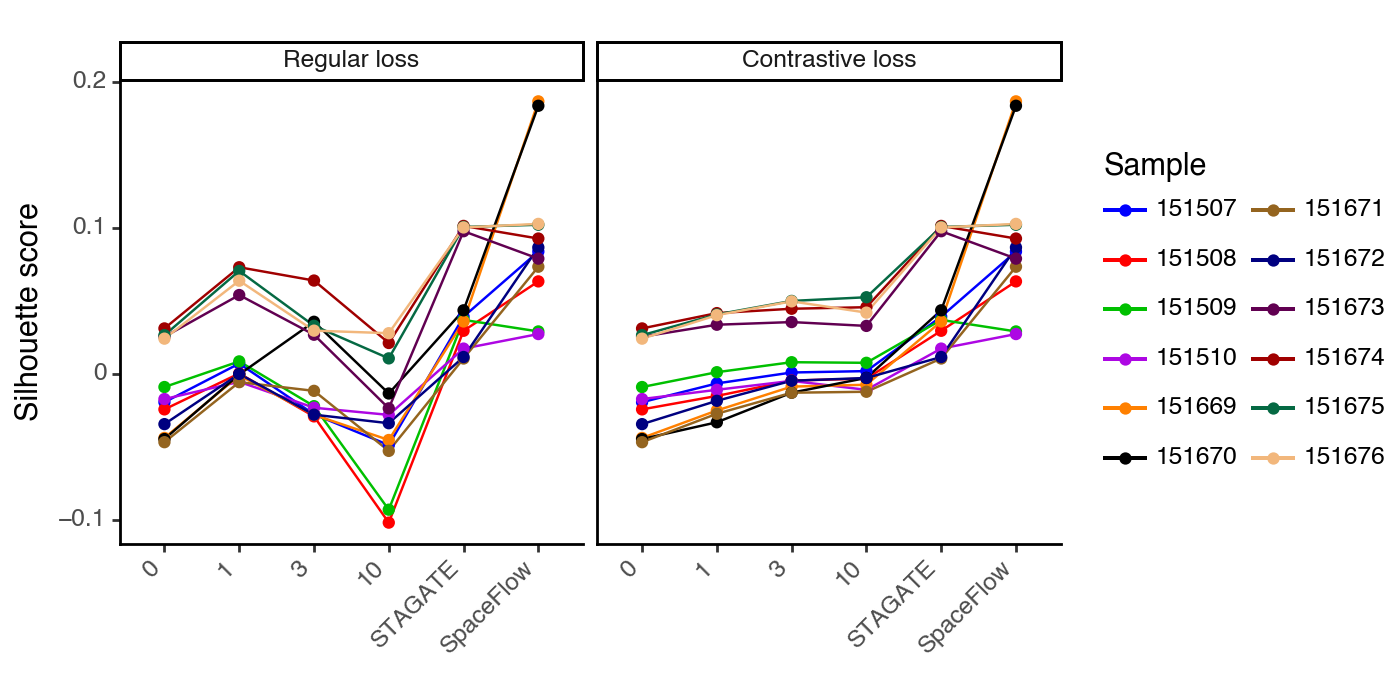

<Figure Size: (700 x 350)>

In [7]:
(
    ggplot(df_pca,
           aes(x = 'l_sp_cat', y = 'silhouette', color = 'sample_id')) + 
    facet_grid('~contrastive', scales = 'free_y') + 
    geom_line(aes(group = 'sample_id')) + 
    geom_point() + 
    scale_color_prism() + 
    labs(x = '', y = 'Silhouette score', color = 'Sample') + 
    theme_classic() +
    guides(color = guide_legend(ncol=2)) + 
    theme(
        figure_size=(7,3.5),
        axis_text_x=element_text(angle = 45, vjust = 1, hjust=1))
)

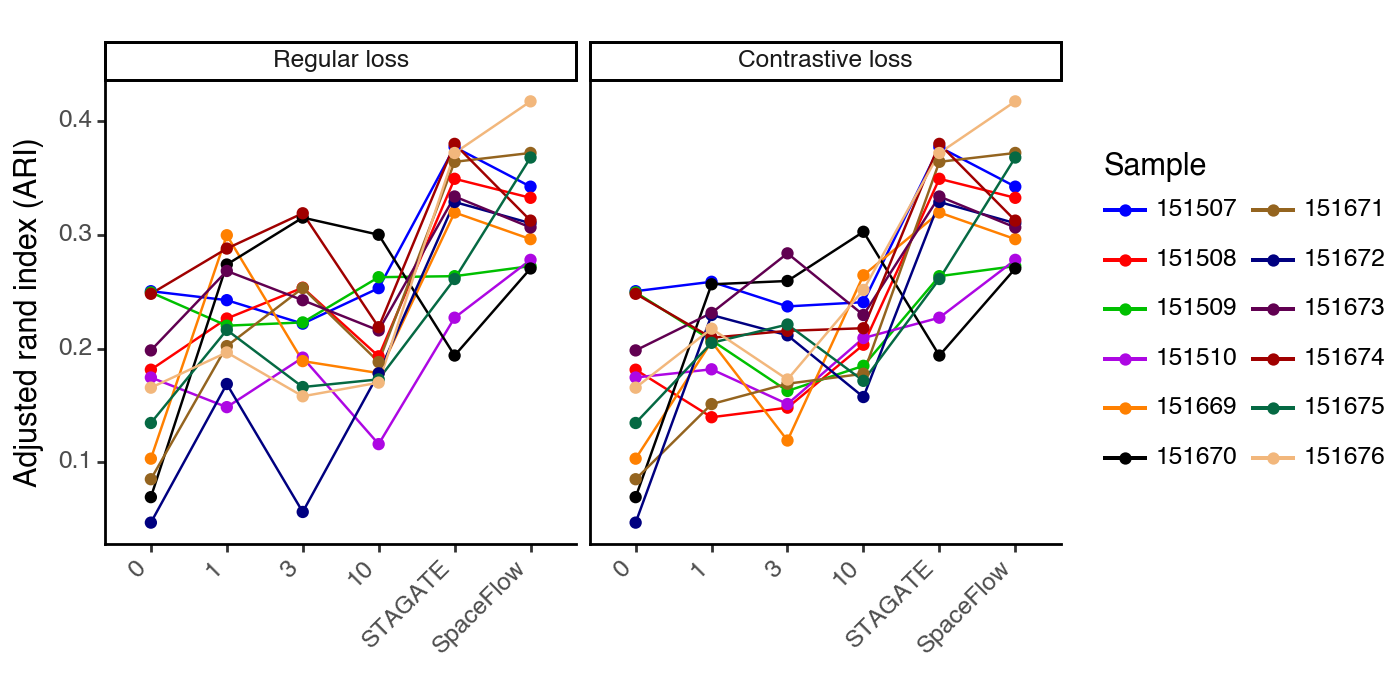

<Figure Size: (700 x 350)>

In [8]:
(
    ggplot(df_pca,
           aes(x = 'l_sp_cat', y = 'ari', color = 'sample_id')) + 
    facet_grid('~contrastive', scales = 'free_y') + 
    geom_line(aes(group = 'sample_id')) + 
    geom_point() + 
    scale_color_prism() + 
    labs(x = '', y = 'Adjusted rand index (ARI)', color = 'Sample') + 
    theme_classic() +
    guides(color = guide_legend(ncol=2)) + 
    theme(
        figure_size=(7,3.5),
        axis_text_x=element_text(angle = 45, vjust = 1, hjust=1))
)

#### UMAP

In [9]:
s = '151509'
data, _ = _load_smoother_dr_res(s, df[df['base'] == 'PCA'])
data.obsm['X_STAGATE'] = np.loadtxt(f"{res_dir}/STAGATE/{s}_STAGATE.txt")
data.obsm['X_SpaceFlow'] = np.loadtxt(f"{res_dir}/SpaceFlow/{s}_SF.tsv", delimiter='\t')

names_list = [
    'PCA_sp_0',
    'PCA_csp_0',
    'PCA_sp_1',
    'PCA_csp_1',
    'PCA_sp_3',
    'PCA_csp_3',
    'PCA_sp_10',
    'PCA_csp_10',
    'STAGATE',
    'SpaceFlow'
]
for m in names_list:
    sc.pp.neighbors(data, use_rep=f"X_{m}", n_neighbors = 10)
    sc.tl.umap(data)
    data.obsm[f"X_umap_{m}"] = data.obsm['X_umap'].copy()

In [10]:
df_umap = []
for m in names_list:
    _df = pd.DataFrame(data.obsm[f"X_umap_{m}"], columns = ['x', 'y'])
    _df['Region'] = data.obs['Region'].values
    _df['model'] = m
    df_umap.append(_df)
df_umap = pd.concat(df_umap)

model_name_dict = {
    'PCA_sp_0': 'Baseline PCA',
    'PCA_sp_1': '+ Spatial loss (l = 1)',
    'PCA_csp_1': '+ Contrastive loss (l = 1)',
    'PCA_sp_10': '+ Spatial loss (l = 10)',
    'PCA_csp_10': '+ Contrastive loss (l = 10)',
    'STAGATE': 'STAGATE',
    'SpaceFlow': 'SpaceFlow',
}
df_umap = df_umap[df_umap['model'].isin(model_name_dict.keys())]
df_umap['name'] = pd.Categorical(
    df_umap['model'], categories=['PCA_sp_0', 'PCA_sp_1', 'PCA_sp_10',
                                 'PCA_csp_1', 'PCA_csp_10', 'STAGATE', 'SpaceFlow'],
    ordered=True
).rename_categories(model_name_dict)

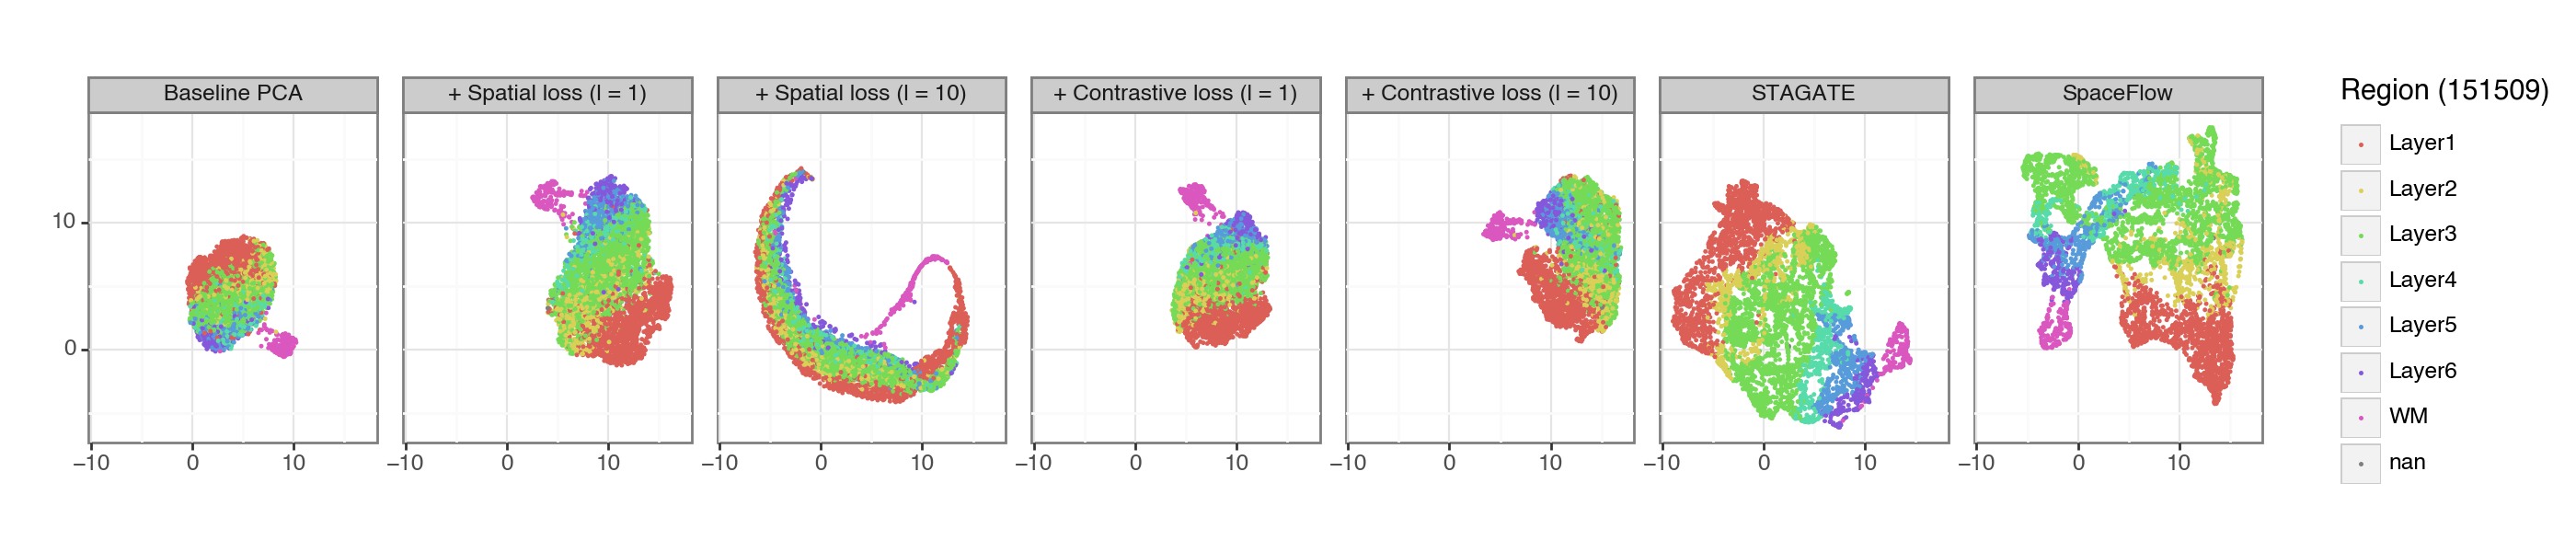

<Figure Size: (1400 x 300)>

In [11]:
(
    ggplot(df_umap, aes(x = 'x', y = 'y', color = 'Region'))+
        facet_wrap('~name', nrow = 1) + 
        geom_point(size = 0.01) + 
        labs(x = '', y = '', color = f'Region ({s})') + 
        theme_bw() + 
        theme(figure_size=(14,3))
    
)

### Spatial AE

#### Scores - Abs

In [12]:
df_nn['base'] = 'AE'
df_ae = pd.concat([df[df['base'] == 'AE'], df_nn])
df_ae['sample_id'] = df_ae['sample_id'].astype(str)
df_ae['l_sp_cat'] = pd.Categorical(
    df_ae['l_sp'].astype(str),
    categories=['0', '1', '3', '10', 'STAGATE', 'SpaceFlow'],
    ordered=True
).rename_categories({
    '0.0': 'Baseline NN (2FC)',
    '1.0': 'NN + SpatialLoss (l = 1)',
    '3.0': 'NN + SpatialLoss (l = 3)',
    '10.0': 'NN + SpatialLoss (l = 10)'
})
df_ae['contrastive'] = pd.Categorical(
    df_ae['contrastive'],
    categories=['Regular loss', 'Contrastive loss'],
    ordered=True
)

In [13]:
df_ae

,Unnamed: 0,base,l_sp,contrastive,model,sample_id,silhouette,ari,l_sp_cat
0,0,AE,0,Contrastive loss,AE_csp_0,151507,-0.020205,0.014684,0
1,1,AE,0,Regular loss,AE_sp_0,151507,-0.020205,0.014684,0
2,2,AE,1,Contrastive loss,AE_csp_1,151507,0.002437,0.145883,1
3,3,AE,1,Regular loss,AE_sp_1,151507,0.008574,0.119353,1
4,4,AE,3,Contrastive loss,AE_csp_3,151507,0.047952,0.210615,3
...,...,...,...,...,...,...,...,...,...
19,19,AE,SpaceFlow,Regular loss,SF,151674,0.092662,0.312485,SpaceFlow
20,20,AE,STAGATE,Regular loss,STAGATE,151675,0.100607,0.261158,STAGATE
21,21,AE,SpaceFlow,Regular loss,SF,151675,0.102097,0.367916,SpaceFlow
22,22,AE,STAGATE,Regular loss,STAGATE,151676,0.100270,0.371886,STAGATE


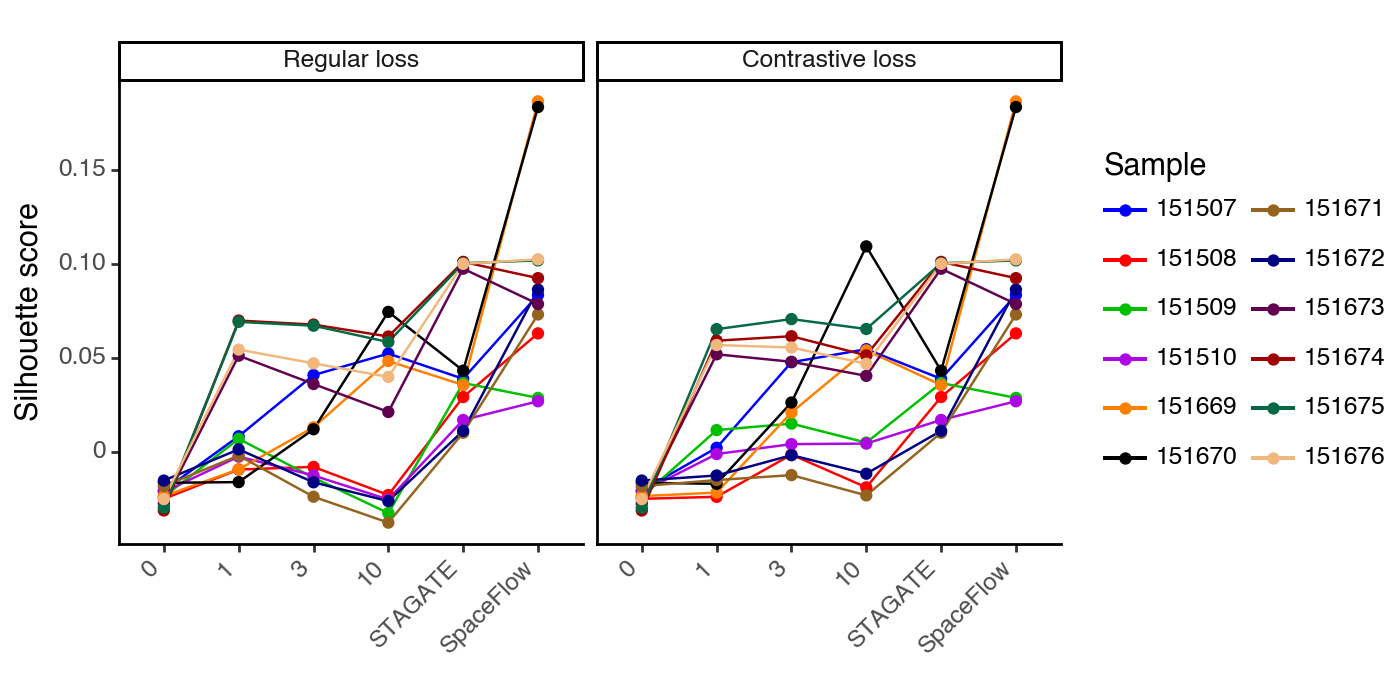

<Figure Size: (700 x 350)>

In [14]:
(
    ggplot(df_ae,
           aes(x = 'l_sp_cat', y = 'silhouette', color = 'sample_id')) + 
    facet_grid('~contrastive', scales = 'free_y') + 
    geom_line(aes(group = 'sample_id')) + 
    geom_point() + 
    scale_color_prism() + 
    labs(x = '', y = 'Silhouette score', color = 'Sample') + 
    theme_classic() +
    guides(color = guide_legend(ncol=2)) + 
    theme(
        figure_size=(7,3.5),
        axis_text_x=element_text(angle = 45, vjust = 1, hjust=1))
)

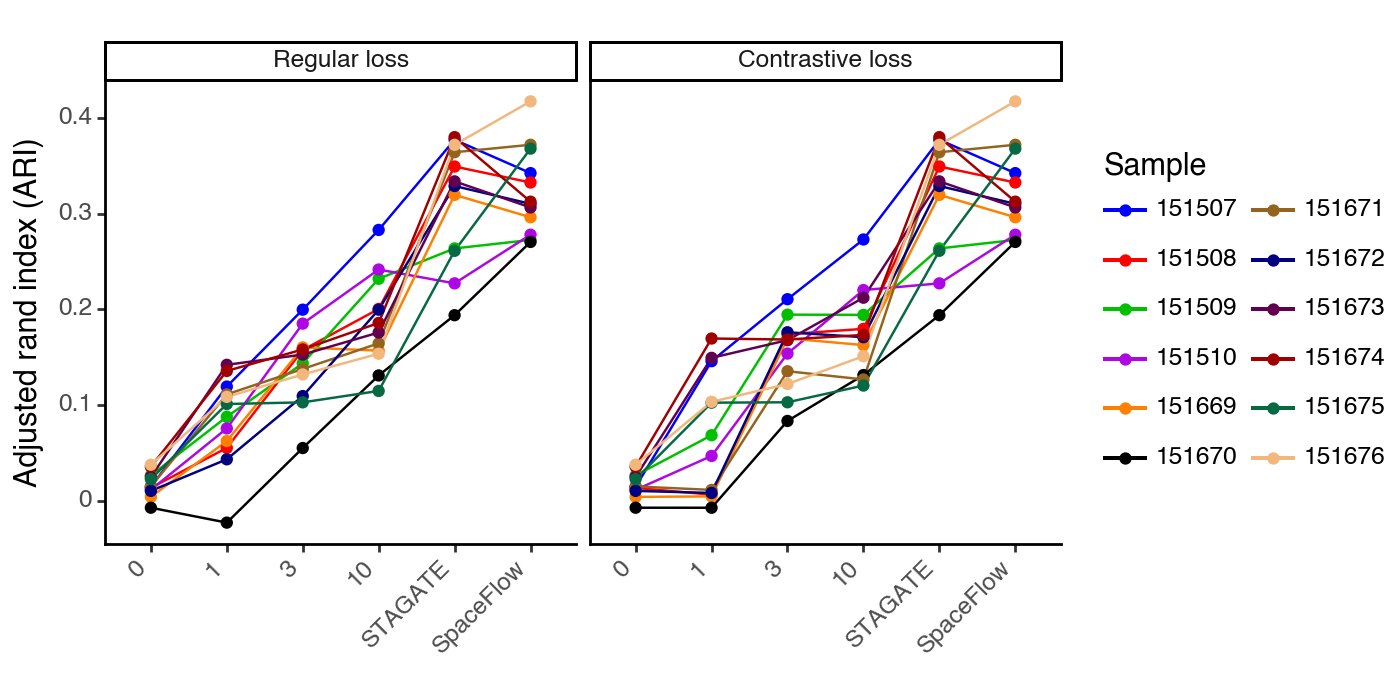

<Figure Size: (700 x 350)>

In [15]:
(
    ggplot(df_ae,
           aes(x = 'l_sp_cat', y = 'ari', color = 'sample_id')) + 
    facet_grid('~contrastive', scales = 'free_y') + 
    geom_line(aes(group = 'sample_id')) + 
    geom_point() + 
    scale_color_prism() + 
    labs(x = '', y = 'Adjusted rand index (ARI)', color = 'Sample') + 
    theme_classic() +
    guides(color = guide_legend(ncol=2)) + 
    theme(
        figure_size=(7,3.5),
        axis_text_x=element_text(angle = 45, vjust = 1, hjust=1))
)

#### Scores - Diff

In [16]:
df_baseline = df[(df['l_sp'] == 0.0) & (df['base'] == 'AE')]
df_baseline['sample_id'] = df_baseline['sample_id'].astype(str)
df_baseline = df_baseline.set_index(['sample_id', 'contrastive'])

df_ae['sil_diff'] = df_ae.apply(
    lambda row: row['silhouette'] - \
        df_baseline.loc[(row['sample_id'], row['contrastive'])]['silhouette'], 1
)

df_ae['ari_diff'] = df_ae.apply(
    lambda row: row['ari'] - \
        df_baseline.loc[(row['sample_id'], row['contrastive'])]['ari'], 1
)

/var/folders/_f/m4v2g8c54gdfks59bp2f2cm80000gn/T/ipykernel_88959/2449332916.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


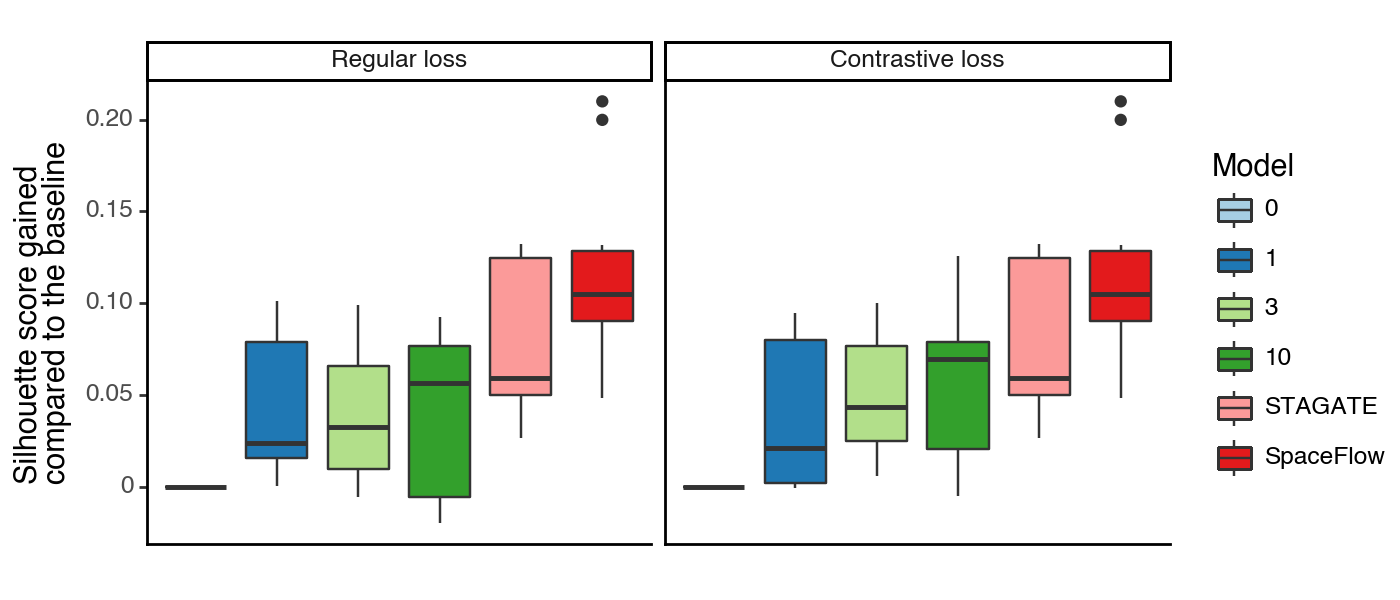

<Figure Size: (700 x 300)>

In [17]:
(
    ggplot(df_ae, aes(x = 'l_sp_cat', y = 'sil_diff')) +
        facet_wrap('~contrastive') + 
        geom_boxplot(aes(fill = 'l_sp_cat')) + 
        labs(x='', y='Silhouette score gained\ncompared to the baseline', fill='Model') + 
        theme_classic() + 
        scale_fill_brewer(palette="Paired", type='qual') + 
        theme(figure_size=(7,3), 
              axis_text_x=element_blank(),
              axis_ticks_major_x=element_blank()
        )
    
)

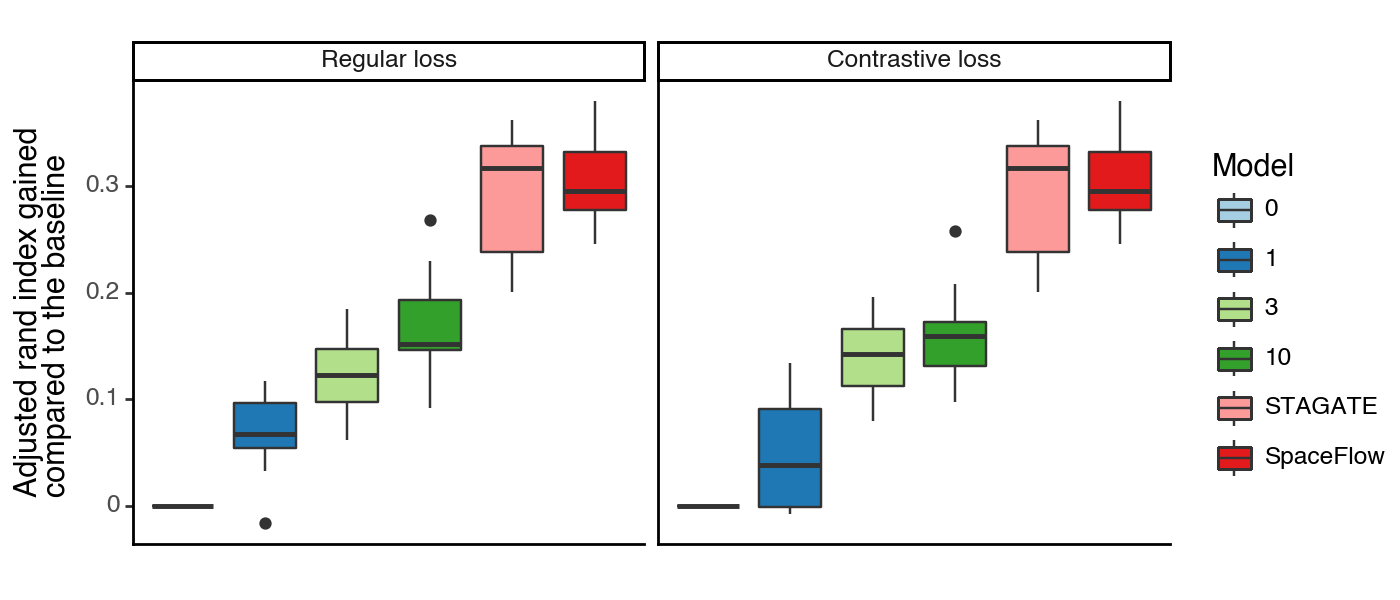

<Figure Size: (700 x 300)>

In [18]:
(
    ggplot(df_ae, aes(x = 'l_sp_cat', y = 'ari_diff')) +
        facet_wrap('~contrastive') + 
        geom_boxplot(aes(fill = 'l_sp_cat')) + 
        labs(x = '', y = 'Adjusted rand index gained\ncompared to the baseline', fill='Model') + 
        theme_classic() + 
        scale_fill_brewer(palette="Paired", type='qual') + 
        theme(figure_size=(7,3), 
              axis_text_x=element_blank(),
              axis_ticks_major_x=element_blank()
        )
    
)

#### UMAP

In [19]:
s = '151507'
data, _ = _load_smoother_dr_res(s, df[df['base'] == 'AE'])
data.obsm['X_STAGATE'] = np.loadtxt(f"{res_dir}/STAGATE/{s}_STAGATE.txt")
data.obsm['X_SpaceFlow'] = np.loadtxt(f"{res_dir}/SpaceFlow/{s}_SF.tsv", delimiter='\t')

names_list = [
    'AE_sp_0',
    'AE_csp_0',
    'AE_sp_1',
    'AE_csp_1',
    'AE_sp_3',
    'AE_csp_3',
    'AE_sp_10',
    'AE_csp_10',
    'STAGATE',
    'SpaceFlow'
]
for m in names_list:
    sc.pp.neighbors(data, use_rep=f"X_{m}", n_neighbors = 10)
    sc.tl.umap(data)
    data.obsm[f"X_umap_{m}"] = data.obsm['X_umap'].copy()

In [20]:
df_umap = []
for m in names_list:
    _df = pd.DataFrame(data.obsm[f"X_umap_{m}"], columns = ['x', 'y'])
    _df['Region'] = data.obs['Region'].values
    _df['model'] = m
    df_umap.append(_df)
df_umap = pd.concat(df_umap)

model_name_dict = {
    'AE_sp_0': 'Baseline NN (2FC)',
    'AE_sp_3': '+ Spatial loss (l = 3)',
    'AE_csp_3': '+ Contrastive loss (l = 3)',
    'AE_sp_10': '+ Spatial loss (l = 10)',
    'AE_csp_10': '+ Contrastive loss (l = 10)',
    'STAGATE': 'STAGATE',
    'SpaceFlow': 'SpaceFlow',
}
df_umap = df_umap[df_umap['model'].isin(model_name_dict.keys())]
df_umap['name'] = pd.Categorical(
    df_umap['model'], categories=['AE_sp_0', 'AE_sp_3', 'AE_sp_10',
                                 'AE_csp_3', 'AE_csp_10', 'STAGATE', 'SpaceFlow'],
    ordered=True
).rename_categories(model_name_dict)

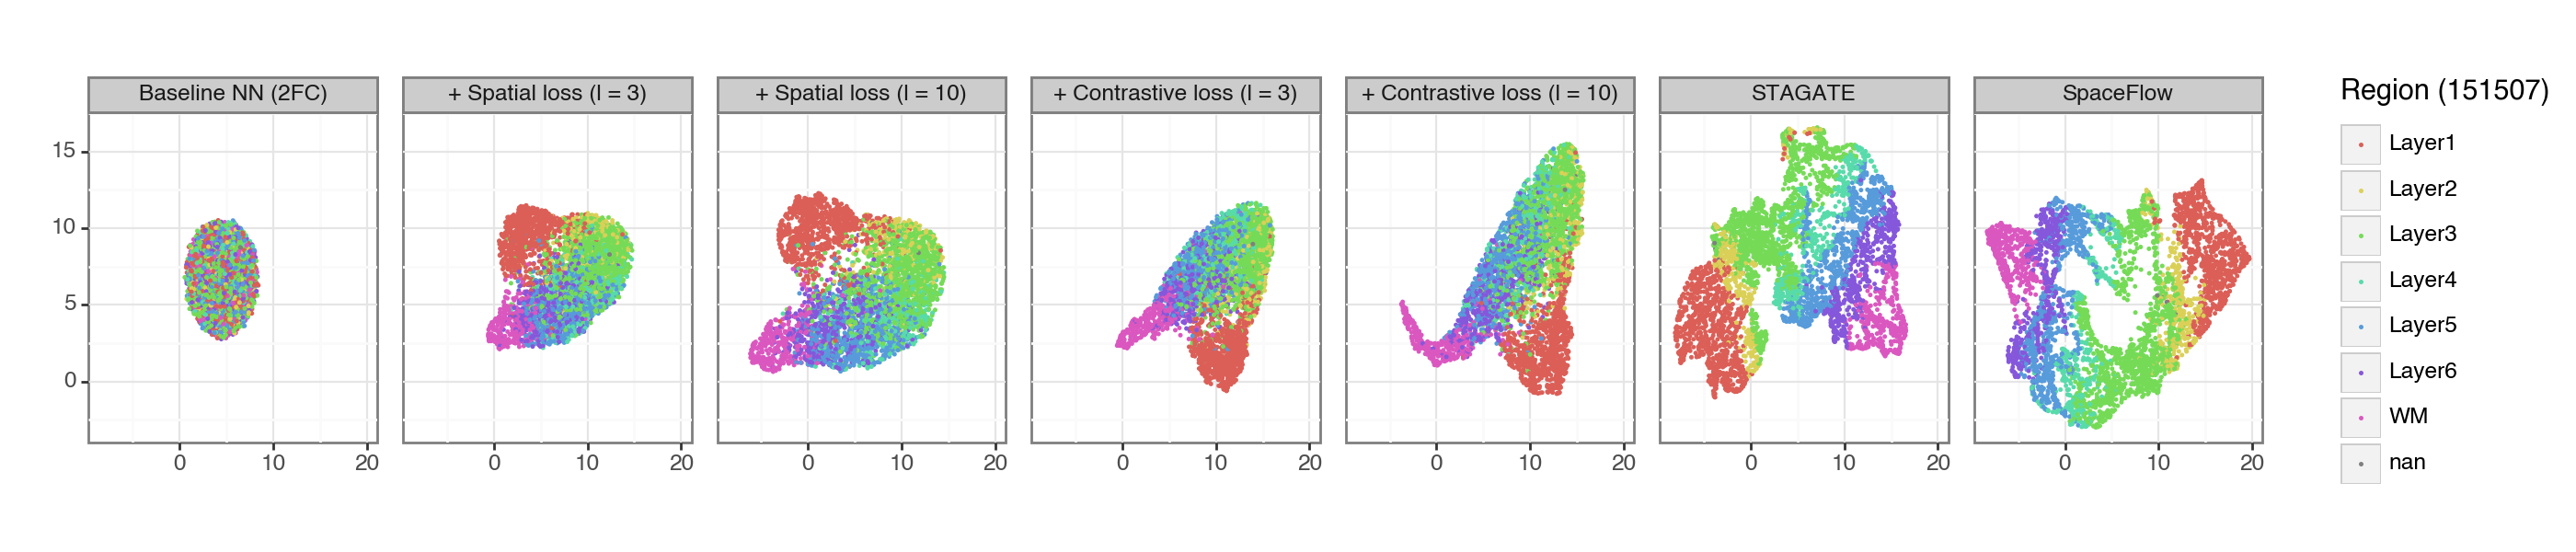

<Figure Size: (1400 x 300)>

In [21]:
(
    ggplot(df_umap, aes(x = 'x', y = 'y', color = 'Region'))+
        facet_wrap('~name', nrow = 1) + 
        geom_point(size = 0.01) + 
        labs(x = '', y = '', color = f'Region ({s})') + 
        theme_bw() + 
        theme(figure_size=(14,3))
    
)